,edad,estado_salud_percibido,ccsr_num_total,ccsr_otra_condicion,categoria_pobreza,tiene_historial_empleo,horas_por_semana,sexo_Male,raza_etnicidad_Non-Hispanic Asian only,raza_etnicidad_Non-Hispanic Black only,...,ccsr_Bacterial infections,ccsr_Osteoarthritis,ccsr_Cataract and other lens disorders,ccsr_Esophageal disorders,ccsr_Retinal and vitreous conditions,ccsr_Other general signs and symptoms,ccsr_Abnormal findings without diagnosis,seguro_Public only,seguro_Uninsured,prima_out_of_pocket_editada
0,29.0,1,7,6,0,1,40.000000,1,0,0,...,1,0,0,0,0,0,0,0,0,357.50
1,51.0,4,4,4,2,1,40.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,215.88
2,53.0,4,10,7,0,1,40.000000,0,0,0,...,0,1,0,1,0,0,1,0,0,315.00
3,69.0,4,6,4,0,0,38.494053,1,0,1,...,0,1,0,0,0,0,0,0,0,315.00
4,37.0,4,1,1,0,1,50.000000,1,0,0,...,0,0,0,0,0,0,0,0,0,140.44


Columnas: ['edad', 'estado_salud_percibido', 'ccsr_num_total', 'ccsr_otra_condicion', 'categoria_pobreza', 'tiene_historial_empleo', 'horas_por_semana', 'sexo_Male', 'raza_etnicidad_Non-Hispanic Asian only', 'raza_etnicidad_Non-Hispanic Black only', 'raza_etnicidad_Non-Hispanic Other race or multi-race', 'raza_etnicidad_Non-Hispanic White only', 'estado_civil_Married', 'estado_civil_Never married', 'estado_civil_Separated', 'estado_civil_Under 16 - not applicable', 'estado_civil_Widowed', 'region_Midwest', 'region_Northeast', 'region_South', 'region_West', 'ccsr_Essential hypertension', 'ccsr_Disorders of lipid metabolism', 'ccsr_Diabetes mellitus without complication', 'ccsr_Bacterial infections', 'ccsr_Osteoarthritis', 'ccsr_Cataract and other lens disorders', 'ccsr_Esophageal disorders', 'ccsr_Retinal and vitreous conditions', 'ccsr_Other general signs and symptoms', 'ccsr_Abnormal findings without diagnosis', 'seguro_Public only', 'seguro_Uninsured', 'prima_out_of_pocket_editada']


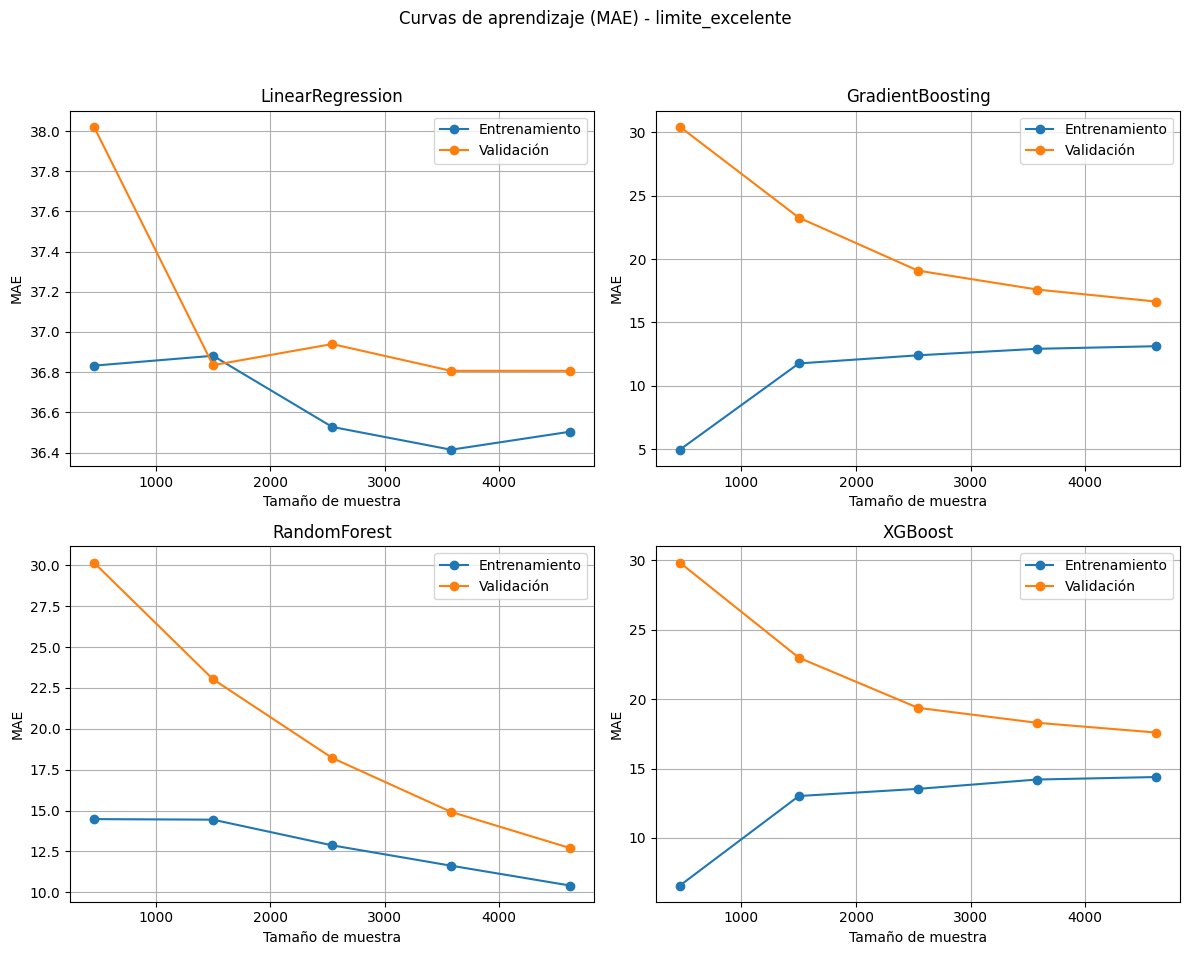

,MAE,RMSE,R2,Bias,Varianza
LinearRegression,34.886444,44.954166,0.230110,-0.026650,858.451381
GradientBoosting,15.444858,21.117555,0.830107,0.041991,2144.255672
RandomForest,8.736520,14.281966,0.922292,-0.041871,2455.733812
XGBoost,15.120859,20.434603,0.840918,0.088686,2113.488281



--- Predicción de: limite_bueno ---
Entrenando y ajustando: LinearRegression
Entrenando y ajustando: GradientBoosting
Entrenando y ajustando: GradientBoosting
Entrenando y ajustando: RandomForest
Entrenando y ajustando: RandomForest
Entrenando y ajustando: XGBoost
Entrenando y ajustando: XGBoost


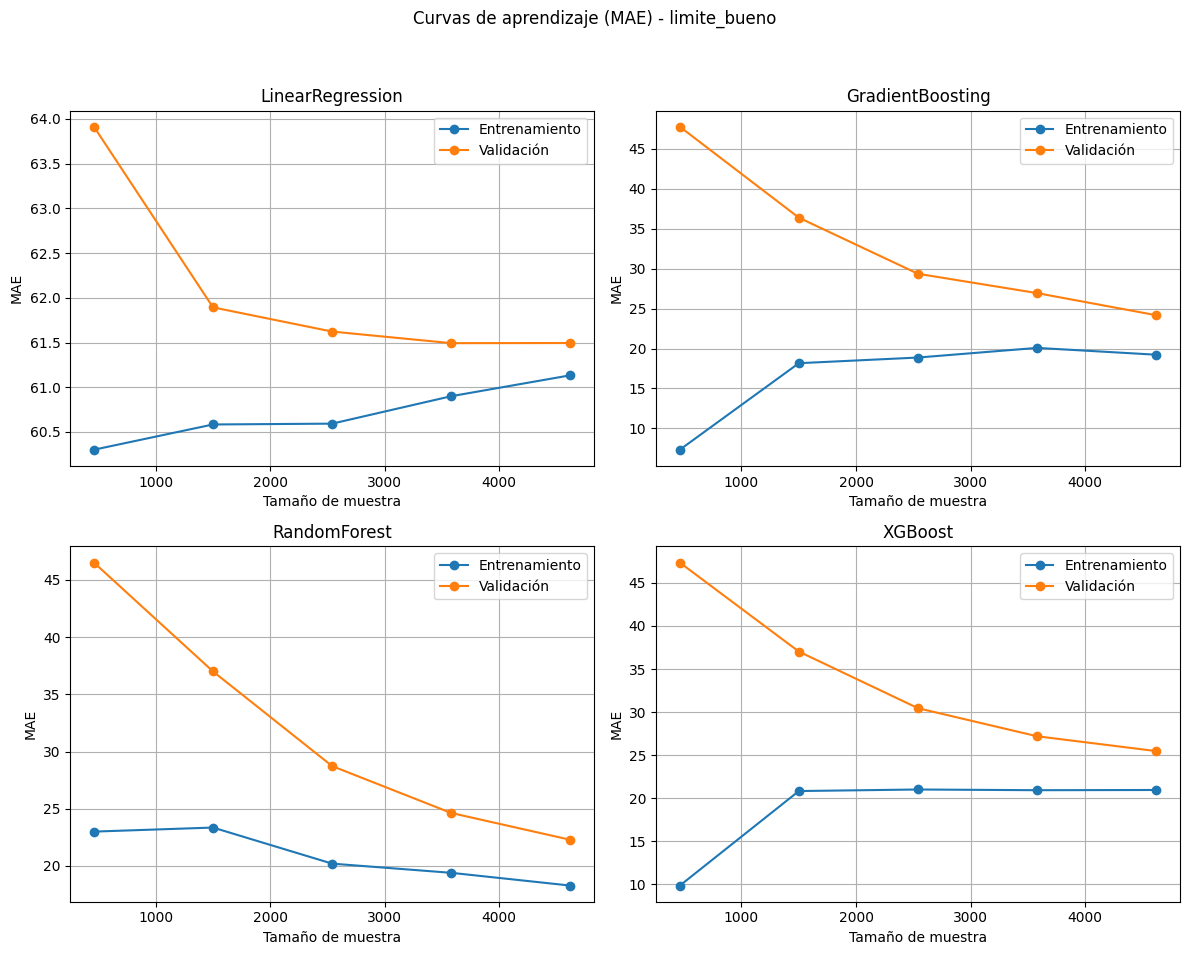

,MAE,RMSE,R2,Bias,Varianza
LinearRegression,60.271530,74.943819,0.226779,-0.013626,1771.508586
GradientBoosting,20.772292,28.526250,0.887973,0.001918,5222.172117
RandomForest,18.098312,26.265672,0.905025,0.110632,5476.058652
XGBoost,20.588624,28.370379,0.889194,0.102079,5173.391602



--- Predicción de: limite_regular ---
Entrenando y ajustando: LinearRegression
Entrenando y ajustando: GradientBoosting
Entrenando y ajustando: GradientBoosting
Entrenando y ajustando: RandomForest
Entrenando y ajustando: RandomForest
Entrenando y ajustando: XGBoost
Entrenando y ajustando: XGBoost


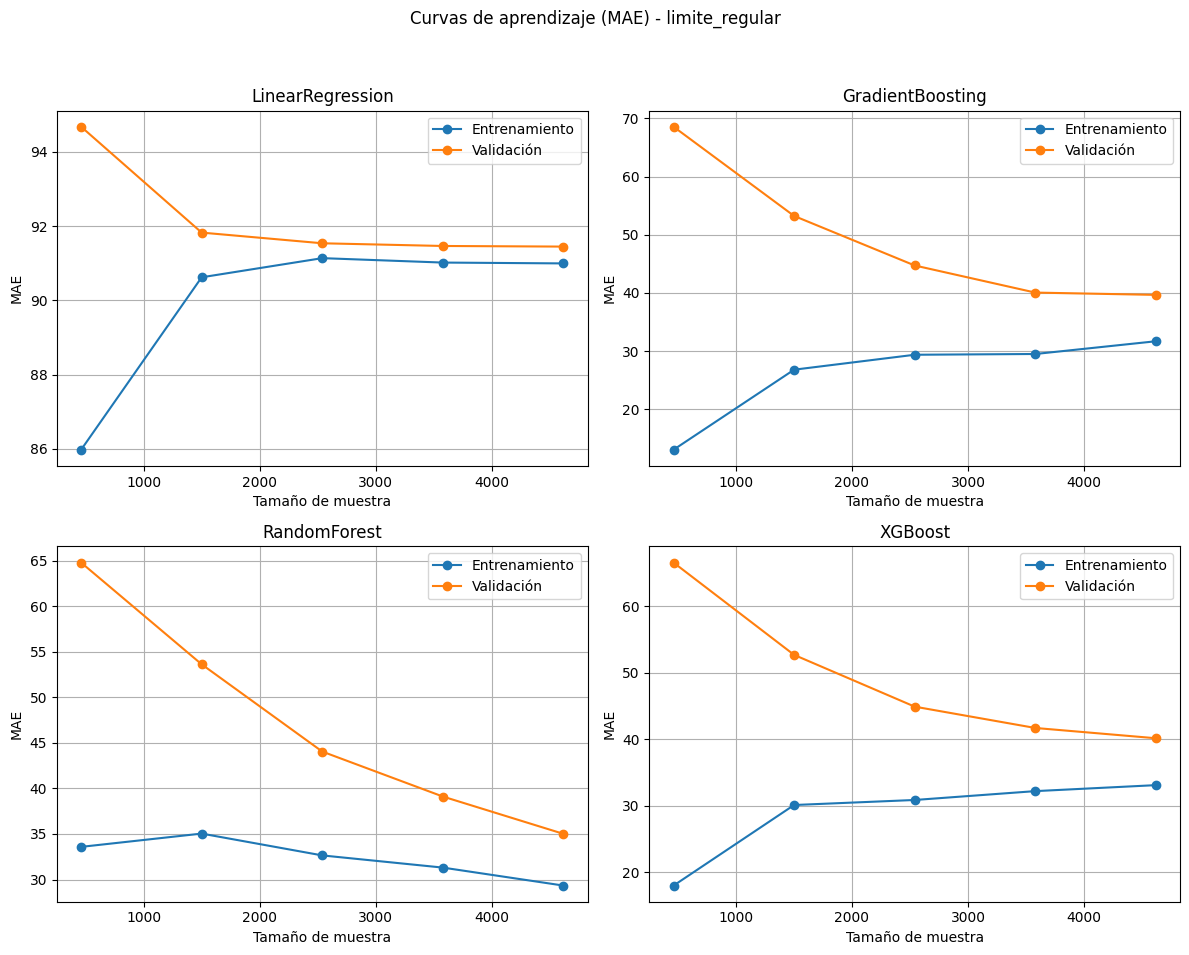

,MAE,RMSE,R2,Bias,Varianza
LinearRegression,90.747954,115.576693,0.142047,0.018605,2354.555810
GradientBoosting,34.724747,49.755312,0.840998,0.158653,10893.461014
RandomForest,28.689491,45.162555,0.868997,0.110757,11379.109762
XGBoost,34.465148,49.428989,0.843077,0.090084,10713.242188


In [21]:
# 1. Importar librerías y cargar el dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_validate
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')
try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    xgb_available = False

# Leer el dataset
df = pd.read_csv('../Models/meps_ml_dataset.csv')
display(df.head())
print('Columnas:', df.columns.tolist())

# Definir todas las columnas de features (excepto el target)
feature_cols = [
    'edad', 'estado_salud_percibido', 'ccsr_num_total', 'ccsr_otra_condicion', 'categoria_pobreza',
    'tiene_historial_empleo', 'horas_por_semana',
    'sexo_Male',
    'raza_etnicidad_Non-Hispanic Asian only', 'raza_etnicidad_Non-Hispanic Black only',
    'raza_etnicidad_Non-Hispanic Other race or multi-race', 'raza_etnicidad_Non-Hispanic White only',
    'estado_civil_Married', 'estado_civil_Never married', 'estado_civil_Separated',
    'estado_civil_Under 16 - not applicable', 'estado_civil_Widowed',
    'region_Midwest', 'region_Northeast', 'region_South', 'region_West',
    'ccsr_Essential hypertension', 'ccsr_Disorders of lipid metabolism', 'ccsr_Diabetes mellitus without complication',
    'ccsr_Bacterial infections', 'ccsr_Osteoarthritis', 'ccsr_Cataract and other lens disorders',
    'ccsr_Esophageal disorders', 'ccsr_Retinal and vitreous conditions', 'ccsr_Other general signs and symptoms',
    'ccsr_Abnormal findings without diagnosis',
    'seguro_Public only', 'seguro_Uninsured'
    # Si hay más columnas de features, agrégalas aquí
    # No incluir 'prima_out_of_pocket_editada'
 ]

# Función para calcular límites personalizados SOLO con datos de entrenamiento (sin fuga de información)
def calcular_limites_por_fila(row, df_train, feature_cols=feature_cols, prima_col='prima_out_of_pocket_editada'):
    # Coincidencia exacta en todos los features
    mask = np.ones(len(df_train), dtype=bool)
    for col in feature_cols:
        mask = mask & (df_train[col] == row[col])
    similares = df_train[mask][prima_col]
    # Si hay muy pocos similares, relajar condiciones: ir quitando features uno a uno (de menos importantes a más importantes)
    relax_order = feature_cols[::-1]  # Empieza quitando los últimos features
    relax_idx = 0
    while len(similares) < 10 and relax_idx < len(relax_order):
        mask = np.ones(len(df_train), dtype=bool)
        for col in feature_cols[:-relax_idx-1]:
            mask = mask & (df_train[col] == row[col])
        similares = df_train[mask][prima_col]
        relax_idx += 1
    # Si aún hay pocos, usar todo el train
    if len(similares) < 10:
        similares = df_train[prima_col]
    q1 = similares.quantile(0.25)
    q2 = similares.quantile(0.5)
    q3 = similares.quantile(0.75)
    return pd.Series([q1, q2, q3])

# 2. Dividir datos en entrenamiento y prueba (antes de crear los targets)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

# 3. Calcular los límites personalizados para cada persona usando SOLO datos de entrenamiento y TODOS los features
df_train[['limite_excelente','limite_bueno','limite_regular']] = df_train.apply(lambda row: calcular_limites_por_fila(row, df_train), axis=1)
df_test[['limite_excelente','limite_bueno','limite_regular']] = df_test.apply(lambda row: calcular_limites_por_fila(row, df_train), axis=1)

# 4. Eliminar outliers usando z-score (umbral 3) en las variables objetivo (por separado en train y test)
z_scores_train = np.abs(zscore(df_train[['limite_excelente','limite_bueno','limite_regular']]))
mask_train = (z_scores_train < 3).all(axis=1)
df_train = df_train[mask_train]
z_scores_test = np.abs(zscore(df_test[['limite_excelente','limite_bueno','limite_regular']]))
mask_test = (z_scores_test < 3).all(axis=1)
df_test = df_test[mask_test]

# 5. Definir variables predictoras y variables objetivo (los tres límites)
X_train = df_train[feature_cols]
y_train = df_train[['limite_excelente','limite_bueno','limite_regular']]
X_test = df_test[feature_cols]
y_test = df_test[['limite_excelente','limite_bueno','limite_regular']]

# 6. Definir modelos y grids de hiperparámetros
modelos_dict = {
    'LinearRegression': (LinearRegression(), {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'positive': [False, True]
    }),
    'GradientBoosting': (GradientBoostingRegressor(random_state=42), {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }),
    'RandomForest': (RandomForestRegressor(random_state=42), {
        'n_estimators': [100, 200],
        'max_depth': [5, 10]
    })
}
if xgb_available:
    modelos_dict['XGBoost'] = (XGBRegressor(random_state=42, objective='reg:squarederror'), {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    })

# 8. Entrenar y comparar modelos para cada límite, graficar 4 curvas en 1 imagen (2x2) y mostrar tabla de métricas
from sklearn.model_selection import cross_val_predict
pd.set_option('display.max_colwidth', None)
for target in y_train.columns:
    print(f'\n--- Predicción de: {target} ---')
    resultados = {}
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()
    for i, (nombre, (modelo, param_grid)) in enumerate(modelos_dict.items()):
        print(f'Entrenando y ajustando: {nombre}')
        if param_grid is not None:
            grid = GridSearchCV(modelo, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
            grid.fit(X_train, y_train[target])
            best_model = grid.best_estimator_
        else:
            modelo.fit(X_train, y_train[target])
            best_model = modelo
        y_pred = best_model.predict(X_test)
        mae = mean_absolute_error(y_test[target], y_pred)
        rmse = mean_squared_error(y_test[target], y_pred, squared=False)
        r2 = r2_score(y_test[target], y_pred)
        # Bias y varianza usando cross_val_predict en train
        y_pred_cv = cross_val_predict(best_model, X_train, y_train[target], cv=5, n_jobs=-1)
        bias = np.mean(y_pred_cv - y_train[target])
        varianza = np.var(y_pred_cv)
        resultados[nombre] = {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Bias': bias, 'Varianza': varianza}
        # Curva de aprendizaje con MAE
        train_sizes, train_scores, test_scores = learning_curve(
            best_model, X_train, y_train[target], cv=3, scoring='neg_mean_absolute_error',
            train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
        )
        train_scores_mean = -np.mean(train_scores, axis=1)
        test_scores_mean = -np.mean(test_scores, axis=1)
        axs[i].plot(train_sizes, train_scores_mean, 'o-', label='Entrenamiento')
        axs[i].plot(train_sizes, test_scores_mean, 'o-', label='Validación')
        axs[i].set_title(f'{nombre}')
        axs[i].set_xlabel('Tamaño de muestra')
        axs[i].set_ylabel('MAE')
        axs[i].legend()
        axs[i].grid(True)
    plt.suptitle(f'Curvas de aprendizaje (MAE) - {target}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    # Mostrar tabla de métricas con bias y varianza
    df_res = pd.DataFrame(resultados).T[['MAE','RMSE','R2','Bias','Varianza']]
    display(df_res)

,MAE promedio,RMSE promedio,R2 promedio,Bias promedio,Varianza promedio
LinearRegression,61.968642,78.491559,0.199645,-0.007224,16977.649827
GradientBoosting,23.647299,33.133039,0.853026,0.067520,21410.939081
RandomForest,18.554910,28.626218,0.898364,0.059170,21764.657673
XGBoost,23.391544,32.744657,0.857730,0.093616,21311.529297


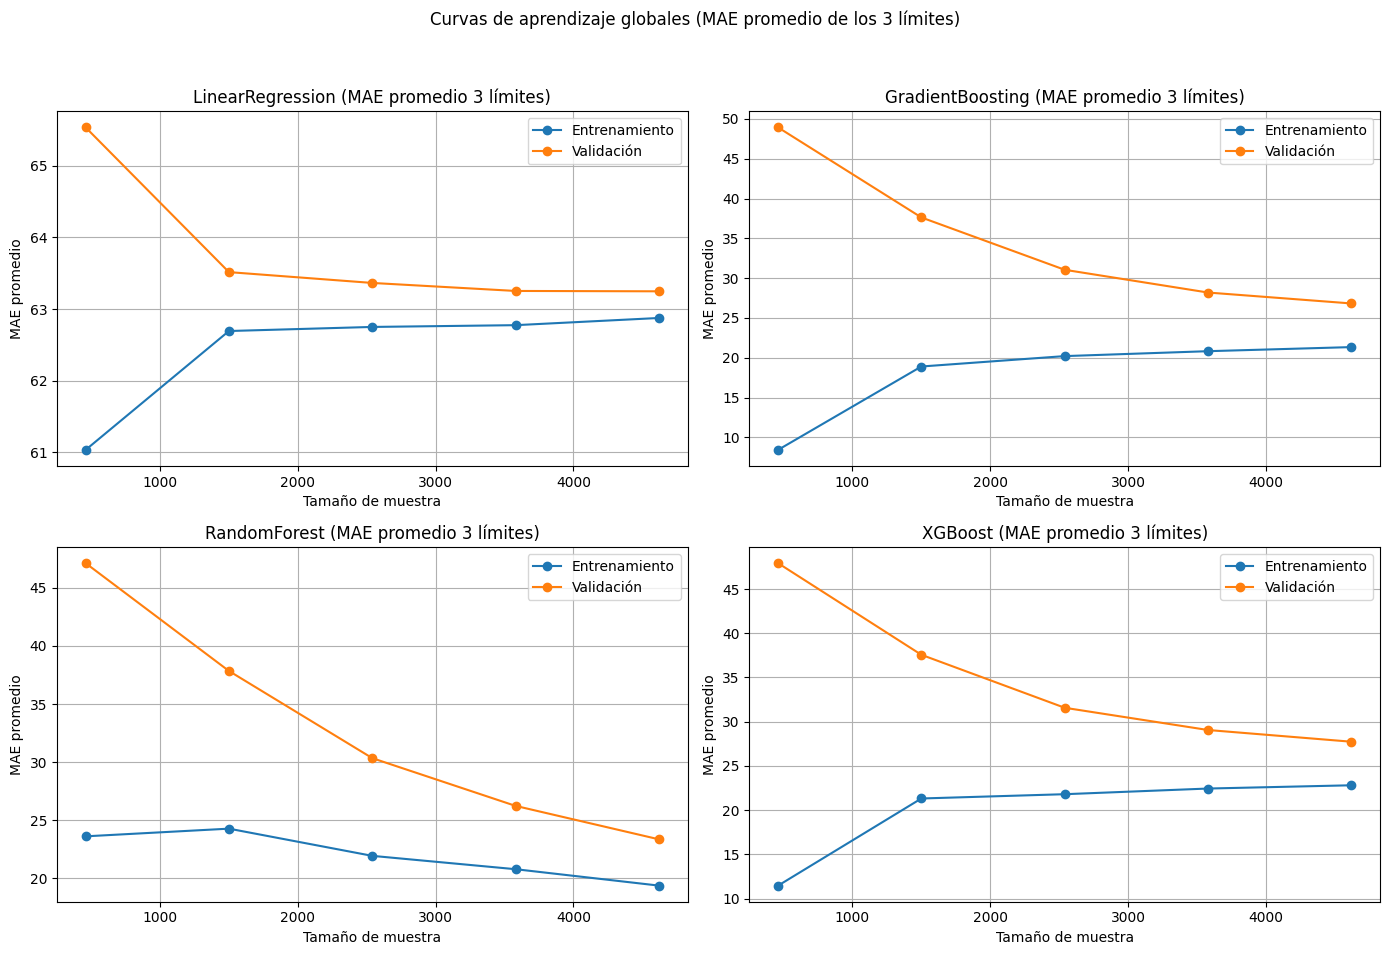

In [29]:
# --- Resumen general: métricas promedio y curvas de aprendizaje globales (3 límites a la vez) ---
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.multioutput import MultiOutputRegressor

# Helper para adaptar el grid a MultiOutputRegressor
from copy import deepcopy

global_results = {}
for nombre, (modelo, param_grid) in modelos_dict.items():
    maes, rmses, r2s, bias_list, var_list = [], [], [], [], []
    # Adaptar el grid para MultiOutputRegressor
    if param_grid is not None:
        # Solo usar los parámetros válidos para el estimador base
        base_params = modelo.get_params().keys()
        grid_multi = {f'estimator__{k}': v for k, v in param_grid.items() if k in base_params}
        grid = GridSearchCV(MultiOutputRegressor(deepcopy(modelo)), grid_multi, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
    else:
        best_model = MultiOutputRegressor(deepcopy(modelo)).fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    maes.append(mean_absolute_error(y_test, y_pred))
    rmses.append(mean_squared_error(y_test, y_pred, squared=False))
    r2s.append(r2_score(y_test, y_pred))
    # Bias y varianza globales
    y_pred_cv = cross_val_predict(best_model, X_train, y_train, cv=5, n_jobs=-1)
    bias_list.append(np.mean(y_pred_cv - y_train))
    var_list.append(np.var(y_pred_cv))
    global_results[nombre] = {
        'MAE promedio': np.mean(maes),
        'RMSE promedio': np.mean(rmses),
        'R2 promedio': np.mean(r2s),
        'Bias promedio': np.mean(bias_list),
        'Varianza promedio': np.mean(var_list)
    }

# Mostrar tabla resumen de métricas globales
import pandas as pd
df_global = pd.DataFrame(global_results).T[['MAE promedio','RMSE promedio','R2 promedio','Bias promedio','Varianza promedio']]
display(df_global)

# Curvas de aprendizaje globales (MAE promedio de los 3 límites)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()
for i, (nombre, (modelo, param_grid)) in enumerate(modelos_dict.items()):
    if param_grid is not None:
        base_params = modelo.get_params().keys()
        grid_multi = {f'estimator__{k}': v for k, v in param_grid.items() if k in base_params}
        best_model = GridSearchCV(MultiOutputRegressor(deepcopy(modelo)), grid_multi, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
        best_model.fit(X_train, y_train)
        est = best_model.best_estimator_
    else:
        est = MultiOutputRegressor(deepcopy(modelo)).fit(X_train, y_train)
    train_sizes, train_scores, test_scores = learning_curve(
        est, X_train, y_train, cv=3, scoring='neg_mean_absolute_error',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    # Promediar el MAE de los 3 límites
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    axs[i].plot(train_sizes, train_scores_mean, 'o-', label='Entrenamiento')
    axs[i].plot(train_sizes, test_scores_mean, 'o-', label='Validación')
    axs[i].set_title(f'{nombre} (MAE promedio 3 límites)')
    axs[i].set_xlabel('Tamaño de muestra')
    axs[i].set_ylabel('MAE promedio')
    axs[i].legend()
    axs[i].grid(True)
plt.suptitle('Curvas de aprendizaje globales (MAE promedio de los 3 límites)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### ¿Cómo se ajustan los hiperparámetros en el entrenamiento con ajuste?

En el bloque de entrenamiento con ajuste de hiperparámetros, los valores óptimos de los hiperparámetros de cada modelo no se eligen manualmente ni se colocan a mano (hardcodeados). En su lugar, se utiliza una técnica de machine learning llamada **búsqueda en malla** (*GridSearchCV* de scikit-learn), que prueba de manera automática todas las combinaciones posibles de los hiperparámetros definidos en un rango (grid) y selecciona la combinación que da el mejor desempeño según la métrica elegida (en este caso, el error absoluto medio negativo en validación cruzada).

Esto permite encontrar de forma objetiva y reproducible los mejores hiperparámetros para cada modelo, evitando el sesgo de selección manual y aprovechando la validación cruzada para estimar el desempeño real.


--- Predicción de: limite_excelente (sin ajuste de hiperparámetros) ---
Entrenando: LinearRegression
Entrenando: GradientBoosting
Entrenando: GradientBoosting
Entrenando: RandomForest
Entrenando: RandomForest
Entrenando: XGBoost
Entrenando: XGBoost


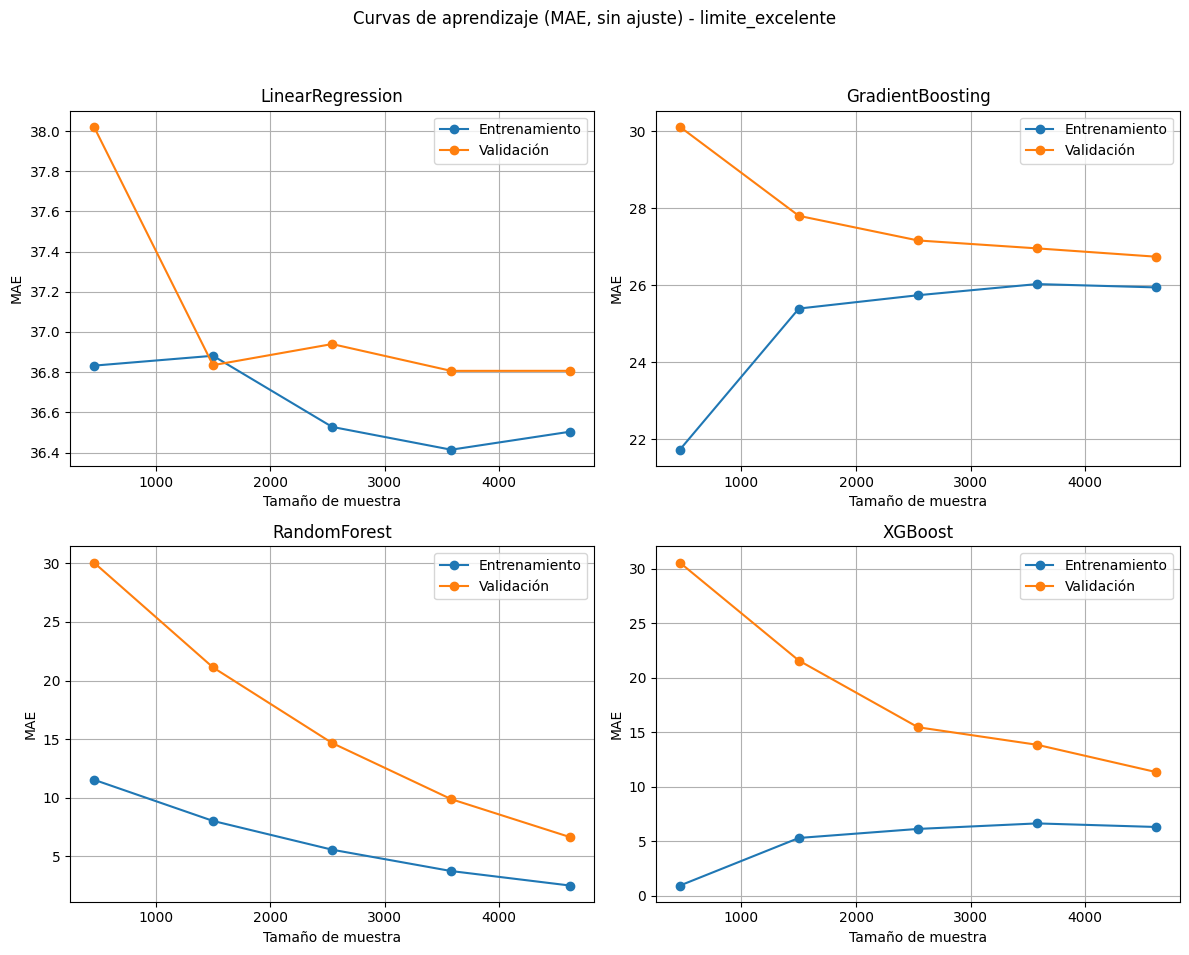

,MAE,RMSE,R2,Bias,Varianza
LinearRegression,34.886444,44.954166,0.230110,-0.026650,858.451381
GradientBoosting,24.662153,32.557194,0.596185,-0.011226,1560.893754
RandomForest,2.592191,5.695745,0.987641,0.071385,2840.151610
XGBoost,9.248279,12.822288,0.937365,0.145528,2558.111084



--- Predicción de: limite_bueno (sin ajuste de hiperparámetros) ---
Entrenando: LinearRegression
Entrenando: GradientBoosting
Entrenando: GradientBoosting
Entrenando: RandomForest
Entrenando: RandomForest
Entrenando: XGBoost
Entrenando: XGBoost


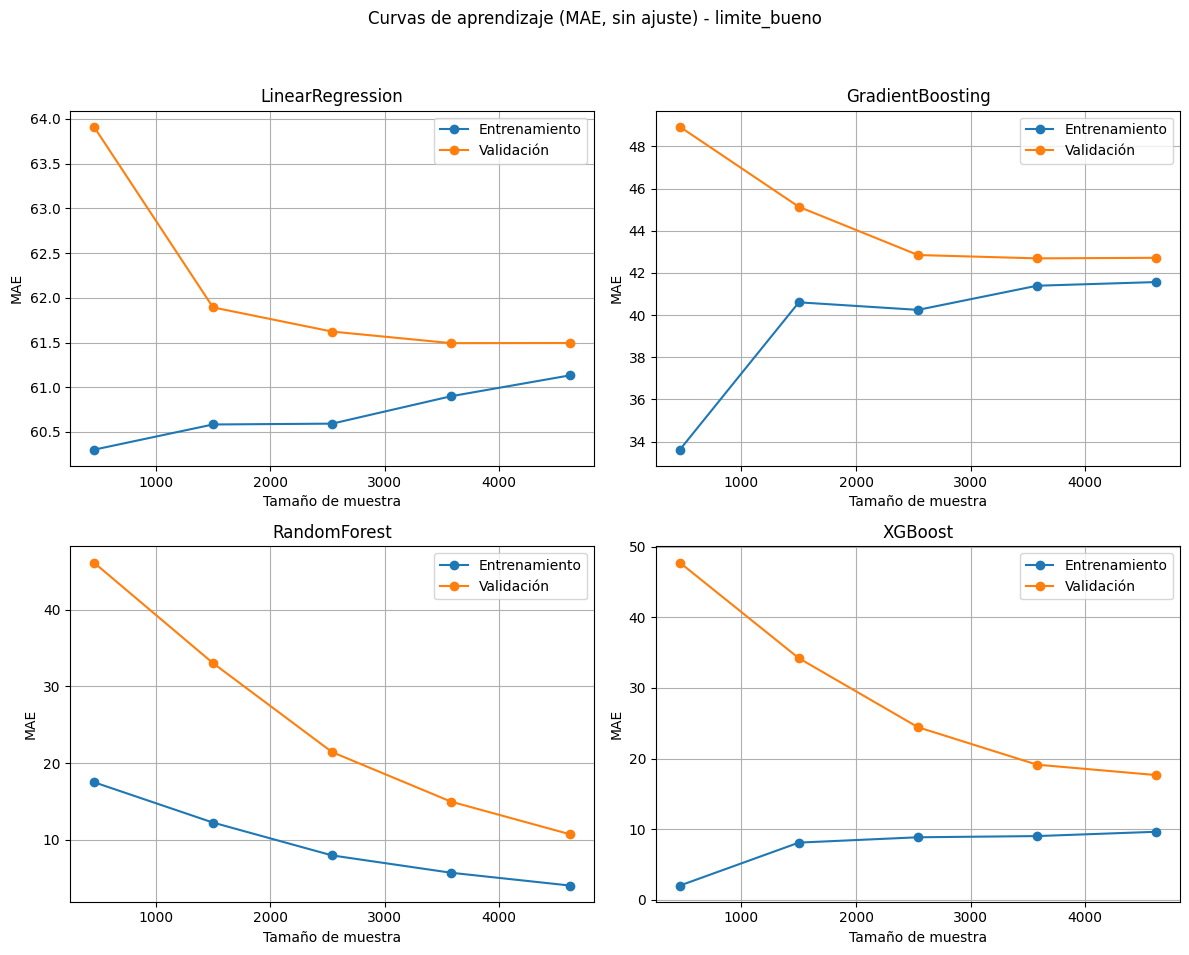

,MAE,RMSE,R2,Bias,Varianza
LinearRegression,60.271530,74.943819,0.226779,-0.013626,1771.508586
GradientBoosting,40.554250,52.970568,0.613721,0.078873,3729.559990
RandomForest,4.908118,10.912026,0.983608,0.039615,6672.124370
XGBoost,13.160717,18.843860,0.951115,0.049380,6239.611328



--- Predicción de: limite_regular (sin ajuste de hiperparámetros) ---
Entrenando: LinearRegression
Entrenando: GradientBoosting
Entrenando: GradientBoosting
Entrenando: RandomForest
Entrenando: RandomForest
Entrenando: XGBoost
Entrenando: XGBoost


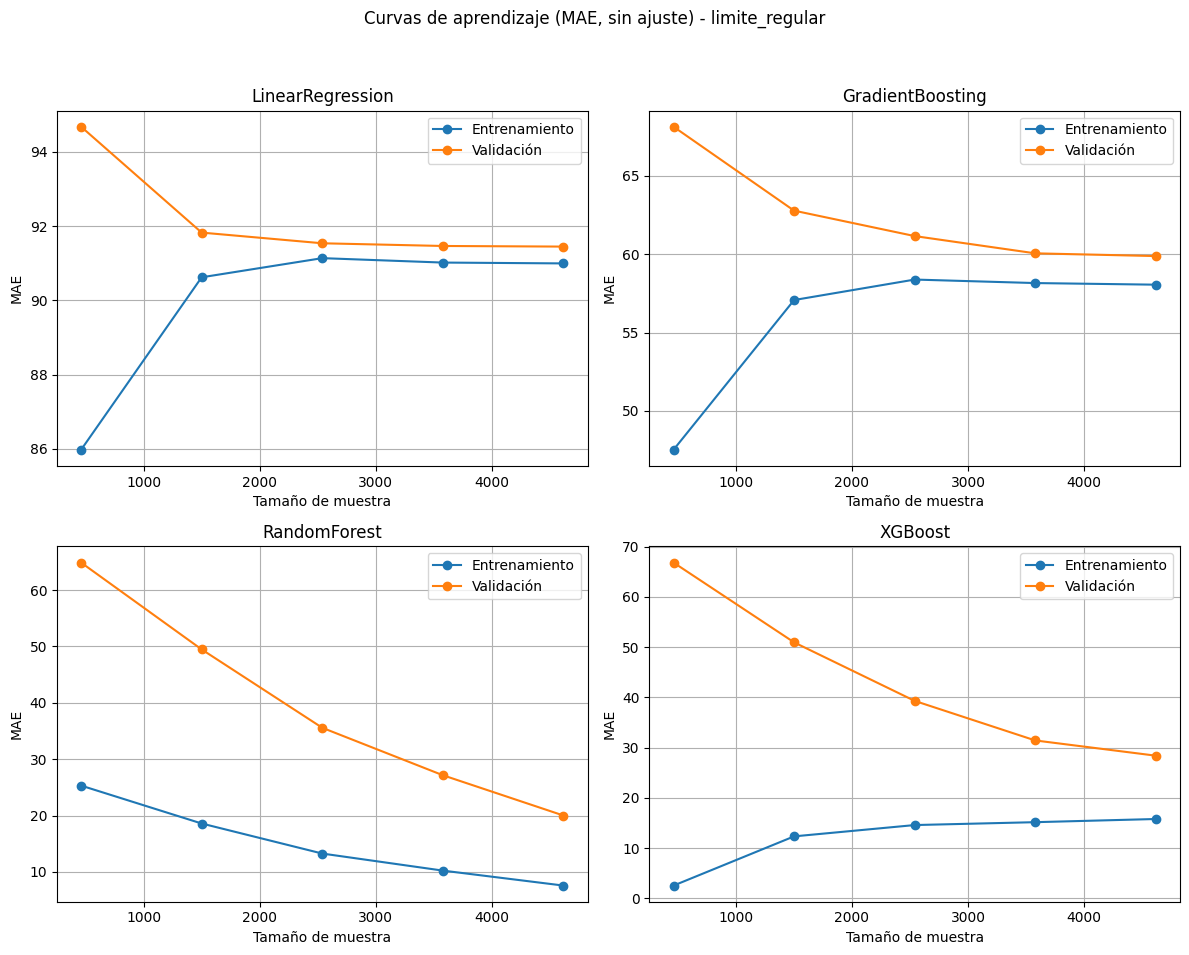

,MAE,RMSE,R2,Bias,Varianza
LinearRegression,90.747954,115.576693,0.142047,0.018605,2354.555810
GradientBoosting,58.566627,78.268901,0.606539,0.104457,8094.812836
RandomForest,10.059288,20.005446,0.974295,0.274444,13549.305556
XGBoost,23.082542,33.105342,0.929609,0.140182,12717.769531


In [22]:
# Entrenamiento y visualización SIN ajuste de hiperparámetros (modelos por defecto)
from copy import deepcopy
from sklearn.model_selection import cross_val_predict

modelos_sin_grid = {
    'LinearRegression': LinearRegression(),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42)
}
if xgb_available:
    modelos_sin_grid['XGBoost'] = XGBRegressor(random_state=42, objective='reg:squarederror')

for target in y_train.columns:
    print(f'\n--- Predicción de: {target} (sin ajuste de hiperparámetros) ---')
    resultados = {}
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()
    for i, (nombre, modelo) in enumerate(modelos_sin_grid.items()):
        print(f'Entrenando: {nombre}')
        modelo_ = deepcopy(modelo)
        modelo_.fit(X_train, y_train[target])
        y_pred = modelo_.predict(X_test)
        mae = mean_absolute_error(y_test[target], y_pred)
        rmse = mean_squared_error(y_test[target], y_pred, squared=False)
        r2 = r2_score(y_test[target], y_pred)
        # Bias y varianza usando cross_val_predict en train
        y_pred_cv = cross_val_predict(modelo_, X_train, y_train[target], cv=5, n_jobs=-1)
        bias = np.mean(y_pred_cv - y_train[target])
        varianza = np.var(y_pred_cv)
        resultados[nombre] = {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Bias': bias, 'Varianza': varianza}
        # Curva de aprendizaje con MAE
        train_sizes, train_scores, test_scores = learning_curve(
            modelo_, X_train, y_train[target], cv=3, scoring='neg_mean_absolute_error',
            train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
        )
        train_scores_mean = -np.mean(train_scores, axis=1)
        test_scores_mean = -np.mean(test_scores, axis=1)
        axs[i].plot(train_sizes, train_scores_mean, 'o-', label='Entrenamiento')
        axs[i].plot(train_sizes, test_scores_mean, 'o-', label='Validación')
        axs[i].set_title(f'{nombre}')
        axs[i].set_xlabel('Tamaño de muestra')
        axs[i].set_ylabel('MAE')
        axs[i].legend()
        axs[i].grid(True)
    plt.suptitle(f'Curvas de aprendizaje (MAE, sin ajuste) - {target}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    # Mostrar tabla de métricas con bias y varianza
    df_res = pd.DataFrame(resultados).T[['MAE','RMSE','R2','Bias','Varianza']]
    display(df_res)


In [23]:
# Validación cruzada para cada modelo y cada límite
from sklearn.model_selection import cross_validate

scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']
for target in y_train.columns:
    print(f"\n--- Validación cruzada para el límite: {target} ---")
    res_cv = {}
    for nombre, modelo in modelos_sin_grid.items():
        scores = cross_validate(
            modelo, X_train, y_train[target],
            cv=5,
            scoring=scoring,
            return_train_score=True,
            n_jobs=-1
        )
        res_cv[nombre] = {
            'MAE (val)': -np.mean(scores['test_neg_mean_absolute_error']),
            'RMSE (val)': -np.mean(scores['test_neg_root_mean_squared_error']),
            'R2 (val)': np.mean(scores['test_r2']),
            'MAE (train)': -np.mean(scores['train_neg_mean_absolute_error']),
            'RMSE (train)': -np.mean(scores['train_neg_root_mean_squared_error']),
            'R2 (train)': np.mean(scores['train_r2'])
        }
    display(pd.DataFrame(res_cv).T)



--- Validación cruzada para el límite: limite_excelente ---


,MAE (val),RMSE (val),R2 (val),MAE (train),RMSE (train),R2 (train)
LinearRegression,36.739470,48.127311,0.264765,36.527187,47.896488,0.272447
GradientBoosting,26.374102,35.663317,0.596347,25.815603,34.824170,0.615347
RandomForest,4.706613,9.216096,0.972977,1.813969,3.570545,0.995955
XGBoost,10.830652,15.356114,0.924367,6.578971,9.633314,0.970434



--- Validación cruzada para el límite: limite_bueno ---


,MAE (val),RMSE (val),R2 (val),MAE (train),RMSE (train),R2 (train)
LinearRegression,61.511159,75.974723,0.227491,61.167798,75.544330,0.236555
GradientBoosting,42.262585,54.593116,0.601097,41.281755,53.285812,0.620153
RandomForest,7.965683,15.083004,0.969463,3.083293,6.003219,0.995169
XGBoost,14.592577,21.023716,0.940594,8.941092,13.045177,0.977195



--- Validación cruzada para el límite: limite_regular ---


,MAE (val),RMSE (val),R2 (val),MAE (train),RMSE (train),R2 (train)
LinearRegression,91.544482,115.862734,0.141545,91.009751,115.255549,0.150664
GradientBoosting,59.366710,79.206478,0.598622,58.048107,77.465861,0.616292
RandomForest,15.307423,27.955380,0.949995,5.786684,10.686869,0.992690
XGBoost,25.432350,37.333071,0.910567,15.572122,23.248697,0.965348



--- Importancia de variables para el límite: limite_excelente (RandomForest) ---


edad                                                    0.776564
estado_salud_percibido                                  0.130479
ccsr_num_total                                          0.050119
ccsr_otra_condicion                                     0.017266
horas_por_semana                                        0.005419
categoria_pobreza                                       0.004419
raza_etnicidad_Non-Hispanic Asian only                  0.001161
sexo_Male                                               0.001152
region_Midwest                                          0.001037
ccsr_Bacterial infections                               0.001031
estado_civil_Never married                              0.001028
raza_etnicidad_Non-Hispanic Other race or multi-race    0.001002
region_South                                            0.000951
region_West                                             0.000943
raza_etnicidad_Non-Hispanic White only                  0.000924
tiene_historial_empleo   

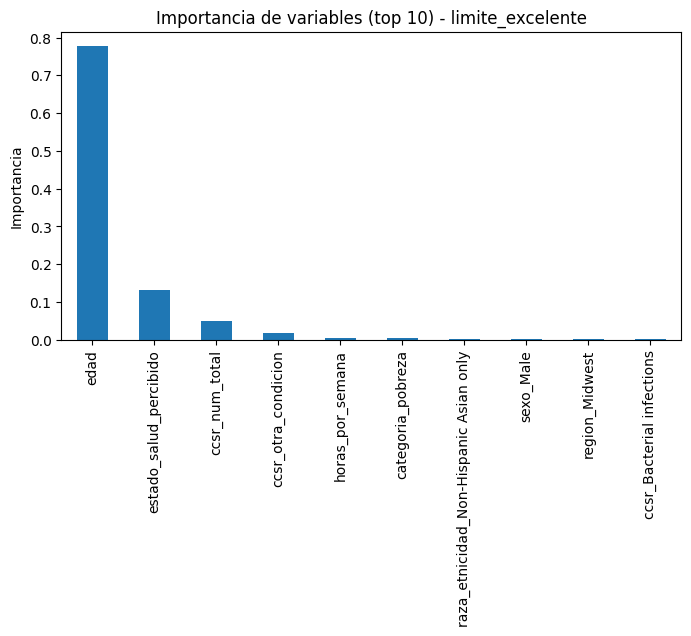


--- Importancia de variables para el límite: limite_bueno (RandomForest) ---


edad                                                    0.768814
estado_salud_percibido                                  0.142319
ccsr_num_total                                          0.047241
ccsr_otra_condicion                                     0.010657
categoria_pobreza                                       0.006495
horas_por_semana                                        0.005624
sexo_Male                                               0.002261
raza_etnicidad_Non-Hispanic Asian only                  0.001917
region_Midwest                                          0.001442
region_Northeast                                        0.001425
region_South                                            0.001191
raza_etnicidad_Non-Hispanic White only                  0.001177
region_West                                             0.001162
raza_etnicidad_Non-Hispanic Black only                  0.001143
estado_civil_Never married                              0.001124
ccsr_Bacterial infections

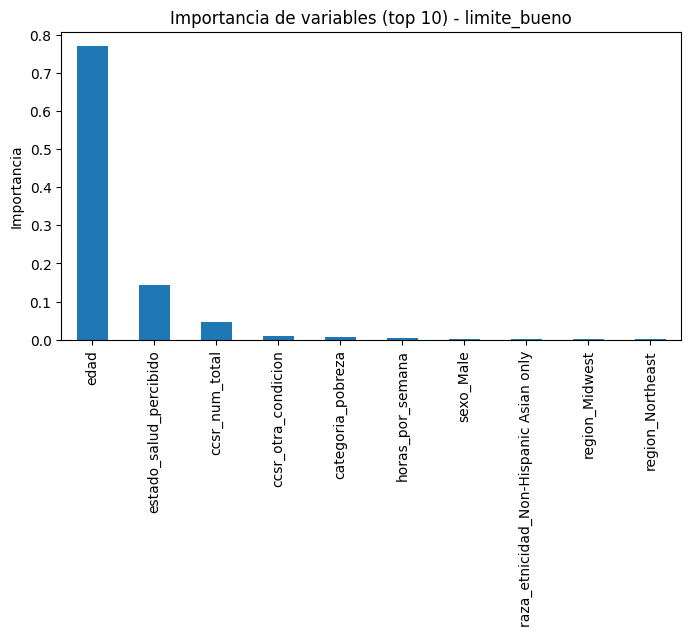


--- Importancia de variables para el límite: limite_regular (RandomForest) ---


edad                                                    0.774960
estado_salud_percibido                                  0.125835
ccsr_num_total                                          0.044671
ccsr_otra_condicion                                     0.011838
horas_por_semana                                        0.009126
categoria_pobreza                                       0.007855
sexo_Male                                               0.002418
region_Northeast                                        0.002007
estado_civil_Never married                              0.001884
region_Midwest                                          0.001871
region_West                                             0.001843
tiene_historial_empleo                                  0.001638
raza_etnicidad_Non-Hispanic Black only                  0.001576
raza_etnicidad_Non-Hispanic White only                  0.001536
region_South                                            0.001432
ccsr_Disorders of lipid m

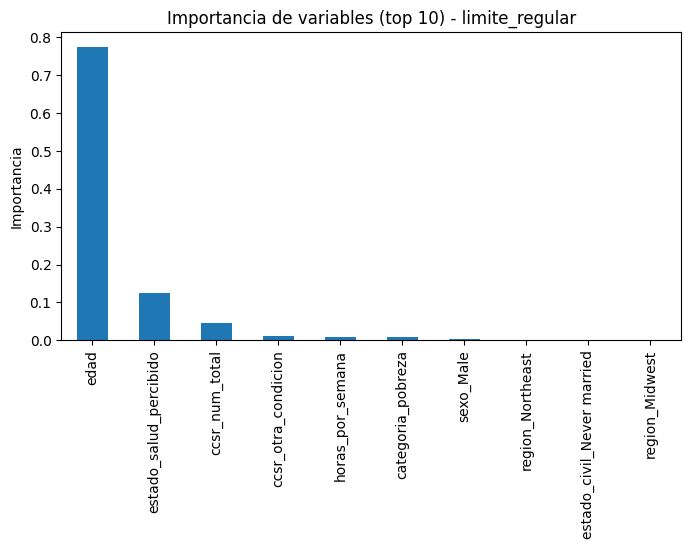


--- Distribución del target: limite_excelente ---


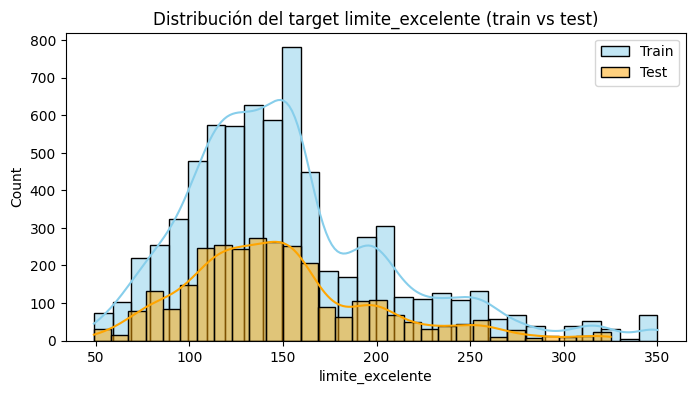


--- Distribución del target: limite_bueno ---


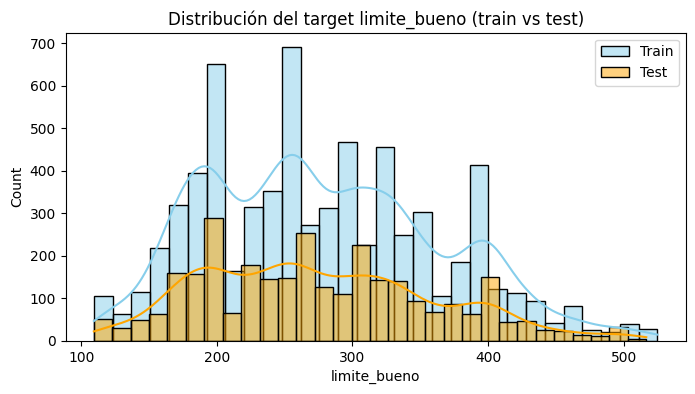


--- Distribución del target: limite_regular ---


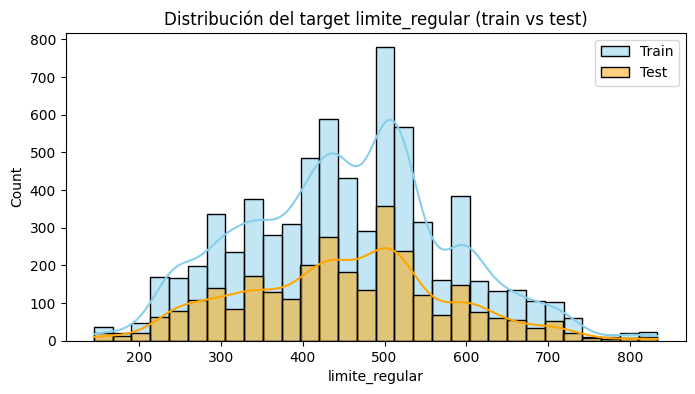

In [24]:
# Revisión de importancia de variables y definición de los targets
importances_dict = {}
for target in y_train.columns:
    print(f"\n--- Importancia de variables para el límite: {target} (RandomForest) ---")
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train[target])
    importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    importances_dict[target] = importances
    display(importances)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,4))
    importances.head(10).plot(kind='bar')
    plt.title(f'Importancia de variables (top 10) - {target}')
    plt.ylabel('Importancia')
    plt.show()

# Revisión de la distribución de los targets
for target in y_train.columns:
    print(f"\n--- Distribución del target: {target} ---")
    plt.figure(figsize=(8,4))
    sns.histplot(y_train[target], kde=True, bins=30, color='skyblue', label='Train')
    sns.histplot(y_test[target], kde=True, bins=30, color='orange', label='Test')
    plt.title(f'Distribución del target {target} (train vs test)')
    plt.legend()
    plt.show()